# Step 1: load a pre-trained ResNet model
            The name of the model is my_resnet_L5.h5
            The input of the model is an gray image with size (224,224,1)
            The output of the model is a 256-dimensional vector-- face embedding          

In [2]:
from keras.models import load_model
#model_opti = load_model('my_resnet_L4.h5')
model_opti = load_model('model_256_80epoch.h5')
from keras.preprocessing import image
import cv2

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# step 2: An example of an output of the ResNet model
            Read an image which is aligned face cropped from an original image
            Get the size of the image
            Normalize the image
            The output of the image (dimension from 224*224*1 to 256)

In [5]:
img= cv2.imread('E:/training_face/Aaron_Peirsol/Aaron_Peirsol_0001.jpg')

In [6]:
path = 'E:/training_face/Aaron_Peirsol/Aaron_Peirsol_0001.jpg'
path.split('/')[-2]

'Aaron_Peirsol'

In [7]:
img.shape

(256, 256, 3)

In [8]:
img = cv2.resize(img,(224,224))
img =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [9]:
img.shape

(224, 224)

In [10]:
img = img/255.0

In [11]:
img=img.reshape(1,224,224,1)

In [16]:
from keras.models import Model
layer_name = 'embedding'
intermediate_layer_model = Model(inputs=model_opti.input,
                                 outputs=model_opti.get_layer(layer_name).output)
#intermediate_output = intermediate_layer_model.predict(data)

In [17]:
intermediate_output = intermediate_layer_model.predict(img)

In [18]:
intermediate_output

array([[-2.25438606e-02, -6.80614412e-02, -3.16460314e-03,
         3.19350399e-02, -5.70128150e-02, -2.92899478e-02,
         5.83813824e-02,  5.89550175e-02,  1.41250491e-02,
         3.79018113e-02, -2.43338384e-02,  3.62047143e-02,
        -9.57377777e-02,  6.53382614e-02,  9.88579777e-05,
        -8.72559100e-03,  9.38119516e-02, -1.06987737e-01,
         1.95712745e-02,  5.56256389e-03, -1.20951748e-02,
         1.34005165e-02, -2.80788559e-02,  4.54734974e-02,
         1.36030223e-02, -3.50581333e-02,  6.42751679e-02,
         3.01543456e-02,  6.08890364e-03,  8.15052912e-02,
         4.30133156e-02,  9.39009190e-02, -5.28978631e-02,
        -5.56290448e-02,  1.32715389e-01, -5.85310347e-02,
        -1.38942935e-02, -1.10990740e-03, -9.99927707e-03,
         3.30585688e-02,  1.09947585e-01,  3.17737423e-02,
        -4.29831631e-02,  9.15879756e-03, -2.00731438e-02,
         4.01598178e-02,  7.84804747e-02, -3.26023772e-02,
        -7.49550685e-02, -2.39634421e-02,  9.45080742e-0

In [19]:
#l2output 256 dimensional vector
len(intermediate_output[0])

256

# step 3: Split the dataset into a training dataset and a testing dataset
            The dataset is stored in my laptop 'E:/chokepoint/dataset'
            split ratio is 0.3

In [4]:
import cv2
import math 
import os
from subprocess import Popen, PIPE
import tensorflow as tf
import numpy as np
from scipy import misc
from sklearn.model_selection import KFold
from scipy import interpolate
from tensorflow.python.training import training
import random
import re
import math
#from facenet.py
from keras.models import load_model
from keras.models import Model

In [5]:
#get dataset from my computer
def get_dataset(path, has_class_directories=True):
    dataset = []
    path_exp = os.path.expanduser(path)
    classes = [path for path in os.listdir(path_exp) \
                    if os.path.isdir(os.path.join(path_exp, path))]
    classes.sort()
    nrof_classes = len(classes)
    for i in range(nrof_classes):
        class_name = classes[i]
        facedir = os.path.join(path_exp, class_name)
        image_paths = get_image_paths(facedir)
        dataset.append(ImageClass(class_name, image_paths))
  
    return dataset

In [6]:
#used in split dataset
def get_image_paths(facedir):
    image_paths = []
    if os.path.isdir(facedir):
        images = os.listdir(facedir)
        image_paths = [os.path.join(facedir,img) for img in images]
    return image_paths

In [7]:
class ImageClass():
    "Stores the paths to images for a given class"
    def __init__(self, name, image_paths):
        self.name = name
        self.image_paths = image_paths
  
    def __str__(self):
        return self.name + ', ' + str(len(self.image_paths)) + ' images'
  
    def __len__(self):
        return len(self.image_paths)

In [8]:
#split dataset into train_set and test_set
def split_dataset(dataset, split_ratio, min_nrof_images_per_class, mode):
    if mode=='SPLIT_CLASSES':
        nrof_classes = len(dataset)
        class_indices = np.arange(nrof_classes)
        np.random.shuffle(class_indices)
        split = int(round(nrof_classes*(1-split_ratio)))
        train_set = [dataset[i] for i in class_indices[0:split]]
        test_set = [dataset[i] for i in class_indices[split:-1]]
    elif mode=='SPLIT_IMAGES':
        train_set = []
        test_set = []
        for cls in dataset:
            paths = cls.image_paths
            np.random.shuffle(paths)
            nrof_images_in_class = len(paths)
            split = int(math.floor(nrof_images_in_class*(1-split_ratio)))
            if split==nrof_images_in_class:
                split = nrof_images_in_class-1
            if split>=min_nrof_images_per_class and nrof_images_in_class-split>=1:
                train_set.append(ImageClass(cls.name, paths[:split]))
                test_set.append(ImageClass(cls.name, paths[split:]))
    else:
        raise ValueError('Invalid train/test split mode "%s"' % mode)
    return train_set, test_set

In [9]:
#get the input dataset
chokepoint_dataset = get_dataset(path='E:/chokepoint/dataset', has_class_directories=True)

In [10]:
chokepoint_dataset[0].image_paths

['E:/chokepoint/dataset\\0001\\00002314.jpg',
 'E:/chokepoint/dataset\\0001\\00002324.jpg',
 'E:/chokepoint/dataset\\0001\\00002334.jpg',
 'E:/chokepoint/dataset\\0001\\00003122.jpg',
 'E:/chokepoint/dataset\\0001\\00003132.jpg',
 'E:/chokepoint/dataset\\0001\\00003142.jpg',
 'E:/chokepoint/dataset\\0001\\00003152.jpg',
 'E:/chokepoint/dataset\\0001\\00003932.jpg',
 'E:/chokepoint/dataset\\0001\\00003943.jpg',
 'E:/chokepoint/dataset\\0001\\00003950.jpg',
 'E:/chokepoint/dataset\\0001\\00003954.jpg',
 'E:/chokepoint/dataset\\0001\\00003965.jpg']

In [40]:
#split dataset into train_set and test_set
train_set, test_set=split_dataset(dataset=chokepoint_dataset, split_ratio=0.3, min_nrof_images_per_class=1, mode='SPLIT_IMAGES')

In [41]:
# the number of images of every people for traning
len(train_set[0].image_paths)

8

In [42]:
#the number of images of every people for testing
len(test_set[0].image_paths)

4

In [43]:
test_set[0].image_paths

['E:/chokepoint/dataset\\0001\\00003142.jpg',
 'E:/chokepoint/dataset\\0001\\00002314.jpg',
 'E:/chokepoint/dataset\\0001\\00003932.jpg',
 'E:/chokepoint/dataset\\0001\\00003965.jpg']

# Step 4: Transfer an image to a face embedding
             store face embeddings with their coresponding label in a list

In [44]:
#transform face image to embedding
#dataset is training dataset or  testing dataset
#model is h5 file
def get_embedding(dataset, model):
    # initialize the list of known encodings and known names
    knownEncodings = []
    knownNames = []
    model = load_model(model)
    intermediate_layer_model = Model(inputs=model_opti.input, outputs=model_opti.get_layer('embedding').output)
    for image_class in dataset:
        for image_path  in image_class.image_paths:
            img= cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img,(224,224))
            img = img/255.0
            img=img.reshape(1,224,224,3)
            embedding = intermediate_layer_model.predict(img)
            knownEncodings.append(embedding)
            knownNames.append( image_path.split('/')[-2])
    return  [knownEncodings,  knownNames]

In [45]:
#model = load_model('my_resnet_3block_7images.h5')
model = load_model('model_256_80epoch.h5')

In [46]:
# initialize the list of known encodings and known names
knownEncodings = []
knownNames = []
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('embedding').output)
for image_class in train_set:
     for image_path  in image_class.image_paths:
        img= cv2.imread(image_path)
        img = cv2.resize(img,(224,224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img/255.0
        img=img.reshape(1,224,224,1)
        embedding = intermediate_layer_model.predict(img)
        knownEncodings.append(embedding)
        knownNames.append( image_path.split('\\')[-2])

In [47]:
# initialize the embedding of test images
test_knownEncodings = []
test_knownNames = []
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('embedding').output)
for image_class in test_set:
     for image_path  in image_class.image_paths:
        img= cv2.imread(image_path)
        img = cv2.resize(img,(224,224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img/255.0
        img=img.reshape(1,224,224,1)
        embedding = intermediate_layer_model.predict(img)
        test_knownEncodings.append(embedding)
        test_knownNames.append( image_path.split('\\')[-2])

In [48]:
#How to remove dimensions in numpy array? [duplicate]
test_embeddings = []
for test_embedding in test_knownEncodings:
    test_new_embedding = test_embedding.flatten()
    test_embeddings.append( test_new_embedding)

In [49]:
# store test embeddings and label
test_embedding_label = [test_embeddings,test_knownNames ]

In [50]:
# the first face embedding's label
test_embedding_label[1][0]

'0001'

In [51]:
#the first face embedding
test_embedding_label[0][0]

array([ 0.0428201 ,  0.00073127,  0.12814163, -0.08513173, -0.09834137,
       -0.04683892, -0.0476617 , -0.07366414,  0.07400712, -0.03497352,
        0.02072299, -0.00350669, -0.00743625,  0.04013666,  0.1589582 ,
        0.01211985, -0.04095387,  0.06686852, -0.01426421,  0.06764314,
       -0.02475846,  0.13519888, -0.04863518, -0.02968593,  0.12795572,
       -0.02901009, -0.08875091, -0.04809703, -0.00860692, -0.10920657,
        0.10271642, -0.05748999,  0.08151405, -0.06485391, -0.01661332,
       -0.05100757, -0.05460464, -0.07815067, -0.0705444 ,  0.04216841,
       -0.02781361,  0.00577216,  0.0662962 , -0.07752816, -0.12250029,
       -0.00677314,  0.05772591,  0.05386978, -0.078009  ,  0.03565443,
       -0.04630197,  0.05915981, -0.03650049,  0.0040241 ,  0.08894735,
       -0.05251683,  0.042455  , -0.05356051, -0.01321357,  0.02259436,
        0.02961557, -0.07441902,  0.05735265, -0.04993855, -0.07326262,
        0.11401826, -0.01134846,  0.0816543 ,  0.01510337,  0.02

In [52]:
#dimension of a enbedding
len(knownEncodings[0][0])

256

In [53]:
#label in training set
knownNames

['0001',
 '0001',
 '0001',
 '0001',
 '0001',
 '0001',
 '0001',
 '0001',
 '0003',
 '0003',
 '0003',
 '0003',
 '0003',
 '0003',
 '0003',
 '0003',
 '0004',
 '0004',
 '0004',
 '0004',
 '0004',
 '0004',
 '0004',
 '0004',
 '0005',
 '0005',
 '0005',
 '0005',
 '0005',
 '0005',
 '0005',
 '0005',
 '0006',
 '0006',
 '0006',
 '0006',
 '0006',
 '0006',
 '0006',
 '0006',
 '0007',
 '0007',
 '0007',
 '0007',
 '0007',
 '0007',
 '0007',
 '0007',
 '0009',
 '0009',
 '0009',
 '0009',
 '0009',
 '0009',
 '0009',
 '0009',
 '0010',
 '0010',
 '0010',
 '0010',
 '0010',
 '0010',
 '0010',
 '0010',
 '0011',
 '0011',
 '0011',
 '0011',
 '0011',
 '0011',
 '0011',
 '0011',
 '0012',
 '0012',
 '0012',
 '0012',
 '0012',
 '0012',
 '0012',
 '0012',
 '0013',
 '0013',
 '0013',
 '0013',
 '0013',
 '0013',
 '0013',
 '0013',
 '0014',
 '0014',
 '0014',
 '0014',
 '0014',
 '0014',
 '0014',
 '0014',
 '0015',
 '0015',
 '0015',
 '0015',
 '0015',
 '0015',
 '0015',
 '0015',
 '0016',
 '0016',
 '0016',
 '0016',
 '0016',
 '0016',
 '0016',
 

In [54]:
# face embedding for training set
knownEncodings 

[array([[ 0.03060058, -0.13136956,  0.11132602, -0.15392192,  0.0564993 ,
         -0.05466894, -0.05098109, -0.12726946, -0.01960418,  0.02717121,
         -0.0850538 , -0.08898002, -0.01856869,  0.06949785,  0.09662581,
         -0.04571232,  0.08348565, -0.12125103, -0.00094685, -0.09863748,
         -0.06860368,  0.11576525, -0.03988061, -0.01924807,  0.07151339,
         -0.09948955,  0.04285119, -0.13524725, -0.10275673,  0.02963227,
          0.04967555, -0.00932379,  0.05756323, -0.00573715, -0.09021136,
         -0.05795307, -0.05181835,  0.06984983,  0.00130481,  0.02252327,
         -0.07178542, -0.04308446, -0.06445495,  0.00198187,  0.01268512,
         -0.05662773, -0.00664281, -0.0042815 ,  0.00348855,  0.03051691,
         -0.00589597,  0.06381638, -0.08708962,  0.07765161, -0.02456522,
         -0.08085299,  0.09738195, -0.02239013,  0.0265434 ,  0.1001838 ,
          0.02961321, -0.07990264, -0.01647534,  0.02341491, -0.00210664,
          0.0680311 ,  0.11600287,  0.

In [55]:
# a face embedding
knownEncodings[0]

array([[ 0.03060058, -0.13136956,  0.11132602, -0.15392192,  0.0564993 ,
        -0.05466894, -0.05098109, -0.12726946, -0.01960418,  0.02717121,
        -0.0850538 , -0.08898002, -0.01856869,  0.06949785,  0.09662581,
        -0.04571232,  0.08348565, -0.12125103, -0.00094685, -0.09863748,
        -0.06860368,  0.11576525, -0.03988061, -0.01924807,  0.07151339,
        -0.09948955,  0.04285119, -0.13524725, -0.10275673,  0.02963227,
         0.04967555, -0.00932379,  0.05756323, -0.00573715, -0.09021136,
        -0.05795307, -0.05181835,  0.06984983,  0.00130481,  0.02252327,
        -0.07178542, -0.04308446, -0.06445495,  0.00198187,  0.01268512,
        -0.05662773, -0.00664281, -0.0042815 ,  0.00348855,  0.03051691,
        -0.00589597,  0.06381638, -0.08708962,  0.07765161, -0.02456522,
        -0.08085299,  0.09738195, -0.02239013,  0.0265434 ,  0.1001838 ,
         0.02961321, -0.07990264, -0.01647534,  0.02341491, -0.00210664,
         0.0680311 ,  0.11600287,  0.11253076, -0.0

# Step 5: Use kNN to identity faces
            Train the kNN model
            Test the kNN model
            There are total 300 images for 25 people, 200 images for training and 100 images for testing
            The accuracy of kNN is 84%.

In [56]:
# Create and train the KNN classifier
#set n_neighbors  = 3 default
from sklearn import neighbors
def train_knn(embedding_label, n_neighbors=10, knn_algo='ball_tree', metric = 'euclidean', leaf_size = 5):
    #embedding_label is a list, the list[0] is a list of embeddings, the list[1] is a list of labels
    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(embedding_label[0], embedding_label[1])
    return knn_clf

In [57]:
#How to remove dimensions in numpy array? [duplicate]
embeddings = []
for embedding in knownEncodings:
    new_embedding = embedding.flatten()
    embeddings.append( new_embedding)

In [58]:
embedding_label = [embeddings,knownNames ]

In [59]:
knn = train_knn(embedding_label, n_neighbors=5, knn_algo='ball_tree', metric = 'minkowsk')

In [60]:
knn.score(test_embedding_label[0],test_embedding_label[1])

0.79

In [61]:
# the result of the 100 testing image
knn.predict(test_embedding_label[0])

array(['0001', '0001', '0001', '0003', '0003', '0003', '0012', '0012',
       '0004', '0026', '0004', '0004', '0005', '0005', '0006', '0005',
       '0005', '0006', '0013', '0006', '0007', '0020', '0014', '0007',
       '0009', '0009', '0009', '0009', '0010', '0010', '0010', '0010',
       '0011', '0011', '0011', '0011', '0012', '0012', '0012', '0012',
       '0013', '0013', '0013', '0013', '0014', '0019', '0014', '0019',
       '0015', '0015', '0001', '0015', '0016', '0016', '0016', '0016',
       '0014', '0017', '0017', '0017', '0018', '0018', '0018', '0014',
       '0014', '0014', '0019', '0019', '0020', '0020', '0020', '0020',
       '0021', '0014', '0021', '0021', '0022', '0022', '0022', '0022',
       '0023', '0019', '0023', '0023', '0017', '0024', '0024', '0024',
       '0025', '0025', '0025', '0025', '0026', '0026', '0021', '0026',
       '0027', '0027', '0017', '0027'], dtype='<U4')

# step 6: Use softmax classifer to identity faces
             An input of the softmax classifer is a face embedding
             The output of the softmax classifer is the accuracy

In [63]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation
def softmax_classifier():
    model = Sequential()
    model.add(Dense(output_dim=25, input_dim=256, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#estimator.fit(X_train, Y_train)
model = softmax_classifier()

C:\Users\fuxia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", input_dim=256, units=25)`
  


In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                6425      
Total params: 6,425
Trainable params: 6,425
Non-trainable params: 0
_________________________________________________________________


In [65]:
estimator = KerasClassifier(build_fn=softmax_classifier, nb_epoch=10, batch_size=32)
history = estimator.fit(np.array(embedding_label[0]+test_embedding_label[0]), embedding_label[1] + test_embedding_label[1],  validation_split=0.33, epochs = 2000, batch_size=32)

C:\Users\fuxia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", input_dim=256, units=25)`
  


Train on 200 samples, validate on 100 samples
Epoch 1/2000
200/200 [==============================] - 2s 8ms/step - loss: 3.2107 - acc: 0.0600 - val_loss: 3.1891 - val_acc: 0.1200
Epoch 2/2000
200/200 [==============================] - 0s 190us/step - loss: 3.1743 - acc: 0.1200 - val_loss: 3.1617 - val_acc: 0.1600
Epoch 3/2000
200/200 [==============================] - 0s 210us/step - loss: 3.1419 - acc: 0.2200 - val_loss: 3.1344 - val_acc: 0.2500
Epoch 4/2000
200/200 [==============================] - 0s 210us/step - loss: 3.1102 - acc: 0.2850 - val_loss: 3.1081 - val_acc: 0.3100
Epoch 5/2000
200/200 [==============================] - 0s 205us/step - loss: 3.0797 - acc: 0.3950 - val_loss: 3.0820 - val_acc: 0.3600
Epoch 6/2000
200/200 [==============================] - 0s 205us/step - loss: 3.0490 - acc: 0.4850 - val_loss: 3.0566 - val_acc: 0.4500
Epoch 7/2000
200/200 [==============================] - 0s 200us/step - loss: 3.0189 - acc: 0.5550 - val_loss: 3.0312 - val_acc: 0.4800
Epoc

Epoch 61/2000
200/200 [==============================] - 0s 95us/step - loss: 1.7636 - acc: 0.9350 - val_loss: 1.9862 - val_acc: 0.7800
Epoch 62/2000
200/200 [==============================] - 0s 95us/step - loss: 1.7464 - acc: 0.9400 - val_loss: 1.9717 - val_acc: 0.7900
Epoch 63/2000
200/200 [==============================] - 0s 95us/step - loss: 1.7293 - acc: 0.9400 - val_loss: 1.9570 - val_acc: 0.7900
Epoch 64/2000
200/200 [==============================] - 0s 105us/step - loss: 1.7123 - acc: 0.9400 - val_loss: 1.9428 - val_acc: 0.7800
Epoch 65/2000
200/200 [==============================] - 0s 100us/step - loss: 1.6958 - acc: 0.9400 - val_loss: 1.9287 - val_acc: 0.7800
Epoch 66/2000
200/200 [==============================] - 0s 100us/step - loss: 1.6792 - acc: 0.9400 - val_loss: 1.9151 - val_acc: 0.7700
Epoch 67/2000
200/200 [==============================] - 0s 95us/step - loss: 1.6628 - acc: 0.9400 - val_loss: 1.9013 - val_acc: 0.7700
Epoch 68/2000
200/200 [======================

Epoch 121/2000
200/200 [==============================] - 0s 95us/step - loss: 1.0227 - acc: 0.9650 - val_loss: 1.3671 - val_acc: 0.8000
Epoch 122/2000
200/200 [==============================] - 0s 95us/step - loss: 1.0142 - acc: 0.9650 - val_loss: 1.3601 - val_acc: 0.8000
Epoch 123/2000
200/200 [==============================] - 0s 105us/step - loss: 1.0059 - acc: 0.9650 - val_loss: 1.3530 - val_acc: 0.8000
Epoch 124/2000
200/200 [==============================] - 0s 90us/step - loss: 0.9975 - acc: 0.9650 - val_loss: 1.3460 - val_acc: 0.8000
Epoch 125/2000
200/200 [==============================] - 0s 100us/step - loss: 0.9894 - acc: 0.9650 - val_loss: 1.3392 - val_acc: 0.8000
Epoch 126/2000
200/200 [==============================] - 0s 95us/step - loss: 0.9814 - acc: 0.9650 - val_loss: 1.3325 - val_acc: 0.8100
Epoch 127/2000
200/200 [==============================] - 0s 95us/step - loss: 0.9734 - acc: 0.9650 - val_loss: 1.3258 - val_acc: 0.8100
Epoch 128/2000
200/200 [===============

200/200 [==============================] - 0s 80us/step - loss: 0.6560 - acc: 0.9850 - val_loss: 1.0533 - val_acc: 0.8500
Epoch 181/2000
200/200 [==============================] - 0s 75us/step - loss: 0.6517 - acc: 0.9850 - val_loss: 1.0495 - val_acc: 0.8500
Epoch 182/2000
200/200 [==============================] - 0s 75us/step - loss: 0.6471 - acc: 0.9850 - val_loss: 1.0458 - val_acc: 0.8500
Epoch 183/2000
200/200 [==============================] - 0s 85us/step - loss: 0.6427 - acc: 0.9850 - val_loss: 1.0422 - val_acc: 0.8500
Epoch 184/2000
200/200 [==============================] - 0s 80us/step - loss: 0.6384 - acc: 0.9850 - val_loss: 1.0388 - val_acc: 0.8500
Epoch 185/2000
200/200 [==============================] - 0s 80us/step - loss: 0.6342 - acc: 0.9850 - val_loss: 1.0353 - val_acc: 0.8500
Epoch 186/2000
200/200 [==============================] - 0s 75us/step - loss: 0.6299 - acc: 0.9850 - val_loss: 1.0317 - val_acc: 0.8500
Epoch 187/2000
200/200 [==============================] 

Epoch 240/2000
200/200 [==============================] - 0s 85us/step - loss: 0.4485 - acc: 0.9900 - val_loss: 0.8721 - val_acc: 0.8700
Epoch 241/2000
200/200 [==============================] - 0s 110us/step - loss: 0.4459 - acc: 0.9900 - val_loss: 0.8697 - val_acc: 0.8700
Epoch 242/2000
200/200 [==============================] - 0s 100us/step - loss: 0.4433 - acc: 0.9900 - val_loss: 0.8673 - val_acc: 0.8700
Epoch 243/2000
200/200 [==============================] - 0s 100us/step - loss: 0.4408 - acc: 0.9900 - val_loss: 0.8650 - val_acc: 0.8700
Epoch 244/2000
200/200 [==============================] - 0s 100us/step - loss: 0.4382 - acc: 0.9900 - val_loss: 0.8627 - val_acc: 0.8700
Epoch 245/2000
200/200 [==============================] - 0s 100us/step - loss: 0.4357 - acc: 0.9900 - val_loss: 0.8605 - val_acc: 0.8700
Epoch 246/2000
200/200 [==============================] - 0s 100us/step - loss: 0.4332 - acc: 0.9900 - val_loss: 0.8582 - val_acc: 0.8700
Epoch 247/2000
200/200 [===========

200/200 [==============================] - 0s 95us/step - loss: 0.3237 - acc: 0.9950 - val_loss: 0.7586 - val_acc: 0.8700
Epoch 300/2000
200/200 [==============================] - 0s 100us/step - loss: 0.3221 - acc: 0.9950 - val_loss: 0.7573 - val_acc: 0.8700
Epoch 301/2000
200/200 [==============================] - 0s 95us/step - loss: 0.3203 - acc: 0.9950 - val_loss: 0.7558 - val_acc: 0.8700
Epoch 302/2000
200/200 [==============================] - 0s 100us/step - loss: 0.3186 - acc: 0.9950 - val_loss: 0.7542 - val_acc: 0.8700
Epoch 303/2000
200/200 [==============================] - 0s 105us/step - loss: 0.3170 - acc: 0.9950 - val_loss: 0.7526 - val_acc: 0.8700
Epoch 304/2000
200/200 [==============================] - 0s 95us/step - loss: 0.3153 - acc: 0.9950 - val_loss: 0.7507 - val_acc: 0.8700
Epoch 305/2000
200/200 [==============================] - 0s 100us/step - loss: 0.3137 - acc: 0.9950 - val_loss: 0.7492 - val_acc: 0.8700
Epoch 306/2000
200/200 [============================

200/200 [==============================] - 0s 90us/step - loss: 0.2414 - acc: 1.0000 - val_loss: 0.6789 - val_acc: 0.8700
Epoch 359/2000
200/200 [==============================] - 0s 100us/step - loss: 0.2403 - acc: 1.0000 - val_loss: 0.6779 - val_acc: 0.8700
Epoch 360/2000
200/200 [==============================] - 0s 75us/step - loss: 0.2390 - acc: 1.0000 - val_loss: 0.6769 - val_acc: 0.8700
Epoch 361/2000
200/200 [==============================] - 0s 85us/step - loss: 0.2380 - acc: 1.0000 - val_loss: 0.6758 - val_acc: 0.8700
Epoch 362/2000
200/200 [==============================] - 0s 70us/step - loss: 0.2368 - acc: 1.0000 - val_loss: 0.6746 - val_acc: 0.8700
Epoch 363/2000
200/200 [==============================] - 0s 75us/step - loss: 0.2357 - acc: 1.0000 - val_loss: 0.6733 - val_acc: 0.8700
Epoch 364/2000
200/200 [==============================] - 0s 75us/step - loss: 0.2346 - acc: 1.0000 - val_loss: 0.6724 - val_acc: 0.8700
Epoch 365/2000
200/200 [==============================]

Epoch 418/2000
200/200 [==============================] - 0s 80us/step - loss: 0.1834 - acc: 1.0000 - val_loss: 0.6203 - val_acc: 0.8800
Epoch 419/2000
200/200 [==============================] - 0s 80us/step - loss: 0.1826 - acc: 1.0000 - val_loss: 0.6196 - val_acc: 0.8800
Epoch 420/2000
200/200 [==============================] - 0s 70us/step - loss: 0.1818 - acc: 1.0000 - val_loss: 0.6191 - val_acc: 0.8800
Epoch 421/2000
200/200 [==============================] - 0s 80us/step - loss: 0.1810 - acc: 1.0000 - val_loss: 0.6184 - val_acc: 0.8800
Epoch 422/2000
200/200 [==============================] - 0s 75us/step - loss: 0.1802 - acc: 1.0000 - val_loss: 0.6175 - val_acc: 0.8800
Epoch 423/2000
200/200 [==============================] - 0s 75us/step - loss: 0.1794 - acc: 1.0000 - val_loss: 0.6166 - val_acc: 0.8800
Epoch 424/2000
200/200 [==============================] - 0s 75us/step - loss: 0.1787 - acc: 1.0000 - val_loss: 0.6159 - val_acc: 0.8800
Epoch 425/2000
200/200 [=================

Epoch 478/2000
200/200 [==============================] - 0s 90us/step - loss: 0.1419 - acc: 1.0000 - val_loss: 0.5774 - val_acc: 0.8700
Epoch 479/2000
200/200 [==============================] - 0s 90us/step - loss: 0.1414 - acc: 1.0000 - val_loss: 0.5767 - val_acc: 0.8700
Epoch 480/2000
200/200 [==============================] - 0s 120us/step - loss: 0.1408 - acc: 1.0000 - val_loss: 0.5762 - val_acc: 0.8700
Epoch 481/2000
200/200 [==============================] - 0s 100us/step - loss: 0.1402 - acc: 1.0000 - val_loss: 0.5755 - val_acc: 0.8700
Epoch 482/2000
200/200 [==============================] - 0s 90us/step - loss: 0.1397 - acc: 1.0000 - val_loss: 0.5749 - val_acc: 0.8700
Epoch 483/2000
200/200 [==============================] - 0s 95us/step - loss: 0.1391 - acc: 1.0000 - val_loss: 0.5743 - val_acc: 0.8700
Epoch 484/2000
200/200 [==============================] - 0s 100us/step - loss: 0.1385 - acc: 1.0000 - val_loss: 0.5737 - val_acc: 0.8700
Epoch 485/2000
200/200 [==============

200/200 [==============================] - 0s 95us/step - loss: 0.1121 - acc: 1.0000 - val_loss: 0.5462 - val_acc: 0.8700
Epoch 538/2000
200/200 [==============================] - 0s 95us/step - loss: 0.1116 - acc: 1.0000 - val_loss: 0.5456 - val_acc: 0.8700
Epoch 539/2000
200/200 [==============================] - 0s 100us/step - loss: 0.1112 - acc: 1.0000 - val_loss: 0.5450 - val_acc: 0.8700
Epoch 540/2000
200/200 [==============================] - 0s 100us/step - loss: 0.1108 - acc: 1.0000 - val_loss: 0.5446 - val_acc: 0.8700
Epoch 541/2000
200/200 [==============================] - 0s 100us/step - loss: 0.1104 - acc: 1.0000 - val_loss: 0.5440 - val_acc: 0.8700
Epoch 542/2000
200/200 [==============================] - 0s 95us/step - loss: 0.1099 - acc: 1.0000 - val_loss: 0.5434 - val_acc: 0.8700
Epoch 543/2000
200/200 [==============================] - 0s 100us/step - loss: 0.1095 - acc: 1.0000 - val_loss: 0.5429 - val_acc: 0.8700
Epoch 544/2000
200/200 [============================

200/200 [==============================] - 0s 110us/step - loss: 0.0896 - acc: 1.0000 - val_loss: 0.5201 - val_acc: 0.8800
Epoch 597/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0892 - acc: 1.0000 - val_loss: 0.5197 - val_acc: 0.8800
Epoch 598/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0889 - acc: 1.0000 - val_loss: 0.5193 - val_acc: 0.8800
Epoch 599/2000
200/200 [==============================] - 0s 105us/step - loss: 0.0886 - acc: 1.0000 - val_loss: 0.5188 - val_acc: 0.8800
Epoch 600/2000
200/200 [==============================] - 0s 110us/step - loss: 0.0882 - acc: 1.0000 - val_loss: 0.5184 - val_acc: 0.8800
Epoch 601/2000
200/200 [==============================] - 0s 95us/step - loss: 0.0879 - acc: 1.0000 - val_loss: 0.5181 - val_acc: 0.8800
Epoch 602/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0875 - acc: 1.0000 - val_loss: 0.5178 - val_acc: 0.8800
Epoch 603/2000
200/200 [==========================

200/200 [==============================] - 0s 95us/step - loss: 0.0722 - acc: 1.0000 - val_loss: 0.5012 - val_acc: 0.8800
Epoch 656/2000
200/200 [==============================] - 0s 105us/step - loss: 0.0720 - acc: 1.0000 - val_loss: 0.5008 - val_acc: 0.8800
Epoch 657/2000
200/200 [==============================] - 0s 105us/step - loss: 0.0717 - acc: 1.0000 - val_loss: 0.5004 - val_acc: 0.8800
Epoch 658/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0714 - acc: 1.0000 - val_loss: 0.5001 - val_acc: 0.8800
Epoch 659/2000
200/200 [==============================] - 0s 110us/step - loss: 0.0712 - acc: 1.0000 - val_loss: 0.4999 - val_acc: 0.8800
Epoch 660/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0709 - acc: 1.0000 - val_loss: 0.4995 - val_acc: 0.8800
Epoch 661/2000
200/200 [==============================] - 0s 105us/step - loss: 0.0706 - acc: 1.0000 - val_loss: 0.4994 - val_acc: 0.8800
Epoch 662/2000
200/200 [==========================

200/200 [==============================] - 0s 80us/step - loss: 0.0587 - acc: 1.0000 - val_loss: 0.4849 - val_acc: 0.8800
Epoch 715/2000
200/200 [==============================] - 0s 70us/step - loss: 0.0584 - acc: 1.0000 - val_loss: 0.4845 - val_acc: 0.8800
Epoch 716/2000
200/200 [==============================] - 0s 75us/step - loss: 0.0583 - acc: 1.0000 - val_loss: 0.4843 - val_acc: 0.8800
Epoch 717/2000
200/200 [==============================] - 0s 70us/step - loss: 0.0581 - acc: 1.0000 - val_loss: 0.4839 - val_acc: 0.8800
Epoch 718/2000
200/200 [==============================] - 0s 85us/step - loss: 0.0579 - acc: 1.0000 - val_loss: 0.4837 - val_acc: 0.8800
Epoch 719/2000
200/200 [==============================] - 0s 75us/step - loss: 0.0577 - acc: 1.0000 - val_loss: 0.4834 - val_acc: 0.8800
Epoch 720/2000
200/200 [==============================] - 0s 75us/step - loss: 0.0575 - acc: 1.0000 - val_loss: 0.4830 - val_acc: 0.8800
Epoch 721/2000
200/200 [==============================] 

Epoch 774/2000
200/200 [==============================] - 0s 75us/step - loss: 0.0478 - acc: 1.0000 - val_loss: 0.4699 - val_acc: 0.8800
Epoch 775/2000
200/200 [==============================] - 0s 85us/step - loss: 0.0477 - acc: 1.0000 - val_loss: 0.4696 - val_acc: 0.8800
Epoch 776/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0475 - acc: 1.0000 - val_loss: 0.4694 - val_acc: 0.8800
Epoch 777/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0473 - acc: 1.0000 - val_loss: 0.4692 - val_acc: 0.8800
Epoch 778/2000
200/200 [==============================] - 0s 70us/step - loss: 0.0472 - acc: 1.0000 - val_loss: 0.4690 - val_acc: 0.8800
Epoch 779/2000
200/200 [==============================] - 0s 75us/step - loss: 0.0470 - acc: 1.0000 - val_loss: 0.4689 - val_acc: 0.8800
Epoch 780/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0469 - acc: 1.0000 - val_loss: 0.4687 - val_acc: 0.8800
Epoch 781/2000
200/200 [=================

200/200 [==============================] - 0s 95us/step - loss: 0.0393 - acc: 1.0000 - val_loss: 0.4601 - val_acc: 0.8800
Epoch 834/2000
200/200 [==============================] - 0s 105us/step - loss: 0.0392 - acc: 1.0000 - val_loss: 0.4601 - val_acc: 0.8800
Epoch 835/2000
200/200 [==============================] - 0s 90us/step - loss: 0.0391 - acc: 1.0000 - val_loss: 0.4601 - val_acc: 0.8800
Epoch 836/2000
200/200 [==============================] - 0s 105us/step - loss: 0.0389 - acc: 1.0000 - val_loss: 0.4599 - val_acc: 0.8800
Epoch 837/2000
200/200 [==============================] - 0s 95us/step - loss: 0.0388 - acc: 1.0000 - val_loss: 0.4597 - val_acc: 0.8800
Epoch 838/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0387 - acc: 1.0000 - val_loss: 0.4597 - val_acc: 0.8800
Epoch 839/2000
200/200 [==============================] - 0s 90us/step - loss: 0.0385 - acc: 1.0000 - val_loss: 0.4595 - val_acc: 0.8800
Epoch 840/2000
200/200 [=============================

200/200 [==============================] - 0s 95us/step - loss: 0.0324 - acc: 1.0000 - val_loss: 0.4520 - val_acc: 0.8800
Epoch 893/2000
200/200 [==============================] - 0s 105us/step - loss: 0.0323 - acc: 1.0000 - val_loss: 0.4519 - val_acc: 0.8800
Epoch 894/2000
200/200 [==============================] - 0s 95us/step - loss: 0.0322 - acc: 1.0000 - val_loss: 0.4518 - val_acc: 0.8800
Epoch 895/2000
200/200 [==============================] - 0s 105us/step - loss: 0.0321 - acc: 1.0000 - val_loss: 0.4516 - val_acc: 0.8800
Epoch 896/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0320 - acc: 1.0000 - val_loss: 0.4516 - val_acc: 0.8800
Epoch 897/2000
200/200 [==============================] - 0s 95us/step - loss: 0.0319 - acc: 1.0000 - val_loss: 0.4513 - val_acc: 0.8800
Epoch 898/2000
200/200 [==============================] - 0s 105us/step - loss: 0.0318 - acc: 1.0000 - val_loss: 0.4513 - val_acc: 0.8800
Epoch 899/2000
200/200 [============================

Epoch 952/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0268 - acc: 1.0000 - val_loss: 0.4423 - val_acc: 0.8800
Epoch 953/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0267 - acc: 1.0000 - val_loss: 0.4423 - val_acc: 0.8800
Epoch 954/2000
200/200 [==============================] - 0s 120us/step - loss: 0.0266 - acc: 1.0000 - val_loss: 0.4423 - val_acc: 0.8800
Epoch 955/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0265 - acc: 1.0000 - val_loss: 0.4422 - val_acc: 0.8800
Epoch 956/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0264 - acc: 1.0000 - val_loss: 0.4420 - val_acc: 0.8800
Epoch 957/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0264 - acc: 1.0000 - val_loss: 0.4418 - val_acc: 0.8800
Epoch 958/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0263 - acc: 1.0000 - val_loss: 0.4415 - val_acc: 0.8800
Epoch 959/2000
200/200 [==========

200/200 [==============================] - 0s 100us/step - loss: 0.0222 - acc: 1.0000 - val_loss: 0.4376 - val_acc: 0.8700
Epoch 1012/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0222 - acc: 1.0000 - val_loss: 0.4375 - val_acc: 0.8700
Epoch 1013/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0221 - acc: 1.0000 - val_loss: 0.4374 - val_acc: 0.8700
Epoch 1014/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0220 - acc: 1.0000 - val_loss: 0.4373 - val_acc: 0.8700
Epoch 1015/2000
200/200 [==============================] - 0s 106us/step - loss: 0.0220 - acc: 1.0000 - val_loss: 0.4373 - val_acc: 0.8700
Epoch 1016/2000
200/200 [==============================] - 0s 120us/step - loss: 0.0219 - acc: 1.0000 - val_loss: 0.4371 - val_acc: 0.8700
Epoch 1017/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0218 - acc: 1.0000 - val_loss: 0.4372 - val_acc: 0.8700
Epoch 1018/2000
200/200 [===================

200/200 [==============================] - 0s 100us/step - loss: 0.0185 - acc: 1.0000 - val_loss: 0.4329 - val_acc: 0.8700
Epoch 1071/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0185 - acc: 1.0000 - val_loss: 0.4331 - val_acc: 0.8700
Epoch 1072/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0184 - acc: 1.0000 - val_loss: 0.4330 - val_acc: 0.8700
Epoch 1073/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0184 - acc: 1.0000 - val_loss: 0.4330 - val_acc: 0.8700
Epoch 1074/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0183 - acc: 1.0000 - val_loss: 0.4327 - val_acc: 0.8700
Epoch 1075/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0183 - acc: 1.0000 - val_loss: 0.4324 - val_acc: 0.8700
Epoch 1076/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0182 - acc: 1.0000 - val_loss: 0.4322 - val_acc: 0.8700
Epoch 1077/2000
200/200 [==================

200/200 [==============================] - 0s 100us/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.4283 - val_acc: 0.8700
Epoch 1130/2000
200/200 [==============================] - 0s 86us/step - loss: 0.0154 - acc: 1.0000 - val_loss: 0.4281 - val_acc: 0.8700
Epoch 1131/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0154 - acc: 1.0000 - val_loss: 0.4279 - val_acc: 0.8700
Epoch 1132/2000
200/200 [==============================] - 0s 120us/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.4278 - val_acc: 0.8700
Epoch 1133/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.4278 - val_acc: 0.8700
Epoch 1134/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.4278 - val_acc: 0.8700
Epoch 1135/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.4278 - val_acc: 0.8700
Epoch 1136/2000
200/200 [====================

200/200 [==============================] - 0s 100us/step - loss: 0.0129 - acc: 1.0000 - val_loss: 0.4246 - val_acc: 0.8700
Epoch 1189/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0129 - acc: 1.0000 - val_loss: 0.4245 - val_acc: 0.8700
Epoch 1190/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0128 - acc: 1.0000 - val_loss: 0.4244 - val_acc: 0.8700
Epoch 1191/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0128 - acc: 1.0000 - val_loss: 0.4244 - val_acc: 0.8700
Epoch 1192/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0128 - acc: 1.0000 - val_loss: 0.4242 - val_acc: 0.8700
Epoch 1193/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0127 - acc: 1.0000 - val_loss: 0.4242 - val_acc: 0.8700
Epoch 1194/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0127 - acc: 1.0000 - val_loss: 0.4241 - val_acc: 0.8700
Epoch 1195/2000
200/200 [==================

200/200 [==============================] - 0s 60us/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.4229 - val_acc: 0.8700
Epoch 1248/2000
200/200 [==============================] - 0s 60us/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.4230 - val_acc: 0.8700
Epoch 1249/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.4229 - val_acc: 0.8700
Epoch 1250/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.4228 - val_acc: 0.8700
Epoch 1251/2000
200/200 [==============================] - 0s 87us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.4227 - val_acc: 0.8700
Epoch 1252/2000
200/200 [==============================] - 0s 120us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.4226 - val_acc: 0.8700
Epoch 1253/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.4225 - val_acc: 0.8700
Epoch 1254/2000
200/200 [=======================

200/200 [==============================] - 0s 100us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.4208 - val_acc: 0.8700
Epoch 1307/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.4207 - val_acc: 0.8700
Epoch 1308/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.4207 - val_acc: 0.8700
Epoch 1309/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.4207 - val_acc: 0.8700
Epoch 1310/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.4208 - val_acc: 0.8700
Epoch 1311/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.4208 - val_acc: 0.8700
Epoch 1312/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.4208 - val_acc: 0.8700
Epoch 1313/2000
200/200 [===================

200/200 [==============================] - 0s 60us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.8700
Epoch 1366/2000
200/200 [==============================] - 0s 60us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.8700
Epoch 1367/2000
200/200 [==============================] - 0s 60us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.8700
Epoch 1368/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.8700
Epoch 1369/2000
200/200 [==============================] - 0s 60us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.8700
Epoch 1370/2000
200/200 [==============================] - 0s 60us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.4193 - val_acc: 0.8700
Epoch 1371/2000
200/200 [==============================] - 0s 60us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.4193 - val_acc: 0.8700
Epoch 1372/2000
200/200 [=========================

200/200 [==============================] - 0s 80us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.4180 - val_acc: 0.8700
Epoch 1425/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.4179 - val_acc: 0.8700
Epoch 1426/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.4179 - val_acc: 0.8700
Epoch 1427/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.4179 - val_acc: 0.8700
Epoch 1428/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.4180 - val_acc: 0.8700
Epoch 1429/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.4180 - val_acc: 0.8700
Epoch 1430/2000
200/200 [==============================] - 0s 120us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.4181 - val_acc: 0.8700
Epoch 1431/2000
200/200 [===================

200/200 [==============================] - 0s 100us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.4180 - val_acc: 0.8700
Epoch 1484/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.4181 - val_acc: 0.8700
Epoch 1485/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.4181 - val_acc: 0.8700
Epoch 1486/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.4180 - val_acc: 0.8700
Epoch 1487/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.4179 - val_acc: 0.8700
Epoch 1488/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.4180 - val_acc: 0.8700
Epoch 1489/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.4179 - val_acc: 0.8700
Epoch 1490/2000
200/200 [====================

200/200 [==============================] - 0s 100us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.4172 - val_acc: 0.8700
Epoch 1543/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.4174 - val_acc: 0.8700
Epoch 1544/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.4175 - val_acc: 0.8700
Epoch 1545/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.4175 - val_acc: 0.8700
Epoch 1546/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.4176 - val_acc: 0.8700
Epoch 1547/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.4177 - val_acc: 0.8700
Epoch 1548/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.4178 - val_acc: 0.8700
Epoch 1549/2000
200/200 [==================

200/200 [==============================] - 0s 100us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.4181 - val_acc: 0.8700
Epoch 1602/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.4180 - val_acc: 0.8700
Epoch 1603/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.4180 - val_acc: 0.8700
Epoch 1604/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.4180 - val_acc: 0.8700
Epoch 1605/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.4179 - val_acc: 0.8700
Epoch 1606/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.4179 - val_acc: 0.8700
Epoch 1607/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.4179 - val_acc: 0.8700
Epoch 1608/2000
200/200 [===================

200/200 [==============================] - 0s 100us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4195 - val_acc: 0.8700
Epoch 1661/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4197 - val_acc: 0.8700
Epoch 1662/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4199 - val_acc: 0.8700
Epoch 1663/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4201 - val_acc: 0.8700
Epoch 1664/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4202 - val_acc: 0.8700
Epoch 1665/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4202 - val_acc: 0.8700
Epoch 1666/2000
200/200 [==============================] - 0s 60us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.4200 - val_acc: 0.8700
Epoch 1667/2000
200/200 [========================

200/200 [==============================] - 0s 60us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.8700
Epoch 1720/2000
200/200 [==============================] - 0s 60us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.8700
Epoch 1721/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.8700
Epoch 1722/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4192 - val_acc: 0.8700
Epoch 1723/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4193 - val_acc: 0.8700
Epoch 1724/2000
200/200 [==============================] - 0s 60us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4194 - val_acc: 0.8700
Epoch 1725/2000
200/200 [==============================] - 0s 60us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.4194 - val_acc: 0.8700
Epoch 1726/2000
200/200 [========================

200/200 [==============================] - 0s 100us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4196 - val_acc: 0.8700
Epoch 1779/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4197 - val_acc: 0.8700
Epoch 1780/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4198 - val_acc: 0.8700
Epoch 1781/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4201 - val_acc: 0.8800
Epoch 1782/2000
200/200 [==============================] - 0s 120us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.4203 - val_acc: 0.8800
Epoch 1783/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.4203 - val_acc: 0.8800
Epoch 1784/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.4204 - val_acc: 0.8800
Epoch 1785/2000
200/200 [==================

200/200 [==============================] - 0s 80us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.4221 - val_acc: 0.8800
Epoch 1838/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.4220 - val_acc: 0.8800
Epoch 1839/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.4220 - val_acc: 0.8800
Epoch 1840/2000
200/200 [==============================] - 0s 80us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.4219 - val_acc: 0.8800
Epoch 1841/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.4220 - val_acc: 0.8800
Epoch 1842/2000
200/200 [==============================] - 0s 120us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.4221 - val_acc: 0.8800
Epoch 1843/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.4222 - val_acc: 0.8800
Epoch 1844/2000
200/200 [====================

200/200 [==============================] - 0s 78us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4241 - val_acc: 0.8900
Epoch 1897/2000
200/200 [==============================] - 0s 78us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4241 - val_acc: 0.8900
Epoch 1898/2000
200/200 [==============================] - 0s 156us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4241 - val_acc: 0.8800
Epoch 1899/2000
200/200 [==============================] - 0s 78us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4242 - val_acc: 0.8800
Epoch 1900/2000
200/200 [==============================] - 0s 78us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4242 - val_acc: 0.8800
Epoch 1901/2000
200/200 [==============================] - 0s 78us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4243 - val_acc: 0.8800
Epoch 1902/2000
200/200 [==============================] - 0s 78us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4242 - val_acc: 0.8800
Epoch 1903/2000
200/200 [========================

200/200 [==============================] - 0s 120us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4265 - val_acc: 0.8800
Epoch 1956/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4265 - val_acc: 0.8800
Epoch 1957/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4264 - val_acc: 0.8800
Epoch 1958/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4265 - val_acc: 0.8800
Epoch 1959/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4266 - val_acc: 0.8800
Epoch 1960/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.4267 - val_acc: 0.8800
Epoch 1961/2000
200/200 [==============================] - 0s 100us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.4268 - val_acc: 0.8900
Epoch 1962/2000
200/200 [==================

In [192]:
history.history.keys()

dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])

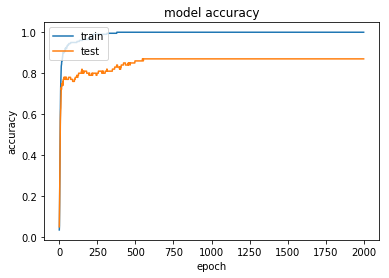

In [206]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [207]:
fig.savefig('C:/Users/fuxia/OneDrive/Desktop/model accuracy.png')

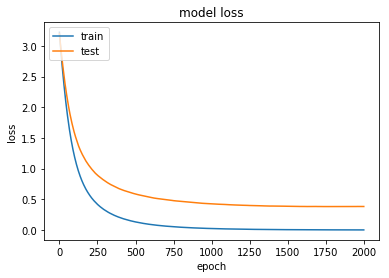

In [203]:
# summarize history for loss
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
#predicted label
predict_results=estimator.predict(np.array(test_embedding_label[0]))

In [77]:
#accuracy
n_samples=len(predict_results)
right_predict=0
for i in range(n_samples):
    if predict_results[i]==test_embedding_label[1][i]:
        right_predict+=1
accuracy=str(int((right_predict/n_samples)*100))+'%'
accuracy

'88%'

# step 7: compare accuracy from kNN and softmax classifier

In [ ]:
# kNN accuracy is 79%
#softmax classifier is 88% 
# different splitting data into training dataset and testing dataset leads to different accuracy
#in above random splitting, softmax classifer is better than kNN, but it may different as the splitting is changed.